## First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** in Hardware accelerator box to enable faster GPU training.

#**Final Project for Coursera's 'How to Win a Data Science Competition'**
April, 2020

Andreas Theodoulou and Michael Gaidis

(Competition Info last updated:  3 years ago)

##**About this Competition**

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Evaluation: root mean squared error (RMSE). True target values are clipped into [0,20] range.

.

##**File descriptions**

***sales_train.csv*** - the training set. Daily historical data from January 2013 to October 2015.

***test.csv*** - the test set. You need to forecast the sales for these shops and products for November 2015.

***sample_submission.csv*** - a sample submission file in the correct format.

***items.csv*** - supplemental information about the items/products.

***item_categories.csv***  - supplemental information about the items categories.

***shops.csv***- supplemental information about the shops.

.

##**Data fields**

***ID*** - an Id that represents a (Shop, Item) tuple within the test set

***shop_id*** - unique identifier of a shop

***item_id*** - unique identifier of a product

***item_category_id*** - unique identifier of item category

***item_cnt_day*** - number of products sold. You are predicting a monthly amount of this measure

***item_price*** - current price of an item

***date*** - date in format dd/mm/yyyy

***date_block_num*** - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

***item_name*** - name of item

***shop_name*** - name of shop

***item_category_name*** - name of item category

#Load Files
Load competition data files and import helpful custom code libraries from shared GitHub repository

In [0]:
# GitHub file location info
git_hub_url = "https://raw.githubusercontent.com/migai/"
repo_name = 'Kag/'
branch_name = 'master/'
base_url = git_hub_url + repo_name + branch_name

# List of the data files (path relative to GitHub branch), to be loaded into pandas DataFrames
data_files = [  "readonly/final_project_data/items.csv",
                "readonly/final_project_data/item_categories.csv",
                "readonly/final_project_data/shops.csv",
                "readonly/final_project_data/sample_submission.csv.gz",
                "readonly/final_project_data/sales_train.csv.gz",
                "readonly/final_project_data/test.csv.gz"  ]

# List of helper code files, to be loaded into Colab and available for python import
code_files = [  "kaggle_utils_at_mg.py"]

In [0]:
import pandas as pd
import os

def xfer_github_to_colab(path):
    filename = path.rsplit("/")[-1]
    os.system("wget " + base_url + "{} -O {}".format(path, filename))
    print(base_url + path + " ---> loaded into ---> " + filename)
    return filename

try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Loading Files from GitHub to Colab\n")

    # Loop to load the above data files into appropriately-named pandas DataFrames
    for path_name in data_files:
      filename = xfer_github_to_colab(path_name)
      data_frame_name = path_name.rsplit("/")[-1].split(".")[0]
      exec(data_frame_name + " = pd.read_csv(filename)")
      print("Data Frame: " + data_frame_name)
      print(eval(data_frame_name).head(2))
      print("\n")


    # to load a code (".py") file into Colab, first shred to make sure you aren't using an old version
    for path_name in code_files:
      filename = path_name.rsplit("/")[-1]
      ! shred -u {filename}
      filename = xfer_github_to_colab(path_name)

Loading Files from GitHub to Colab

https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/items.csv ---> loaded into ---> items.csv
Data Frame: items
                                           item_name  item_id  item_category_id
0          ! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.)         D        0                40
1  !ABBYY FineReader 12 Professional Edition Full...        1                76


https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/item_categories.csv ---> loaded into ---> item_categories.csv
Data Frame: item_categories
        item_category_name  item_category_id
0  PC - Гарнитуры/Наушники                 0
1         Аксессуары - PS2                 1


https://raw.githubusercontent.com/migai/Kag/master/readonly/final_project_data/shops.csv ---> loaded into ---> shops.csv
Data Frame: shops
                       shop_name  shop_id
0  !Якутск Орджоникидзе, 56 фран        0
1  !Якутск ТЦ "Центральный" фран        1


https://ra

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from itertools import product
import time
from sklearn.linear_model import LinearRegression
#from catboost import CatBoostRegressor
import pickle

#from catboost import CatBoostRegressor 

# **Data Preparation**

*   Make data table monthly from daily (is there any point in using the daily data in more advanced modelling versions? Probably just to create more relevant monthly related features (e.g. mean/std or any other type) rather than keeping the format of the table daily)
*   To do: Merge item_category_id as a feature




Make table monthly

In [0]:
matrix = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = sales_train[sales_train.date_block_num==i]
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols,inplace=True)
print("monthly table is")
matrix.head()


monthly table is


,date_block_num,shop_id,item_id
139255,0,0,19
141495,0,0,27
144968,0,0,28
142661,0,0,29
138947,0,0,32


In [0]:
ts = time.time()
group = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
group.columns = ['item_cnt_month']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left')
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))


In [0]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month
10913845,33,59,22162,0.0
10913846,33,59,22163,0.0
10913847,33,59,22164,0.0
10913848,33,59,22166,0.0
10913849,33,59,22167,0.0


In [0]:
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # 34 month
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,6.0,0.0


In [0]:
#Count of monthly data points for each category
#item_id category
matrix[matrix['date_block_num'] <= 6].groupby('item_id').agg({'item_id': 'count'}).describe()
#shop_id category
matrix[matrix['date_block_num'] <= 6].groupby(['shop_id']).agg({'shop_id': 'count'}).describe()
#shop_id & item_id category
matrix[matrix['date_block_num'] <= 6].groupby(['shop_id', 'item_id']).agg({'shop_id': 'count'}).describe()

,shop_id
count,605635.000000
mean,4.374480
std,2.296949
min,1.000000
25%,2.000000
50%,5.000000
75%,7.000000
max,7.000000


In [0]:
sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['count']}).describe()

,item_cnt_day
,count
count,1.609124e+06
mean,1.824501e+00
std,1.981633e+00
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,3.100000e+01


In [0]:
group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean'],
                                                               'item_cnt_day': ['mean']})
group.columns = ['item_price_mean_per_item_and_month', 'item_cnt_mean_per_item_and_month']
group

item_price_mean_per_item_and_month  item_cnt_mean_per_item_and_month
date_block_num item_id                                                                      
0              19                                28.000000                          1.000000
               27                              2325.000000                          1.000000
               28                               549.000000                          1.000000
               29                              2397.500000                          0.666667
               32                               338.110349                          1.328889
...                                                    ...                               ...
33             22162                            349.000000                          1.000000
               22163                            162.698400                          1.040000
               22164                            549.000000                          1.000000
               22166                            150.000000                          1.833333
               22167                            293.098437                          1.156250

[233912 rows x 2 columns]

### **Featue Generation/Engineering**

Time series features
*   Statistics of previous months (e.g. mean of item_price for a specific item/shop in previous months)
*   Trends of previous months - rate of change of the above statistics based features (e.g. rate of change of mean item_price from today to the past 3 months for a specific shop/item)




In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

Stage 1: Statistics based features

> 1st step: Compute their Values


In [0]:
#mean of item price at specific date_block_num and item_id
group = sales_train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean'],
                                                               'item_cnt_day': ['mean']})
group.columns = ['item_price_mean_per_item_and_month', 'item_cnt_mean_per_item_and_month']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['item_price_mean_per_item_and_month'] = matrix['item_price_mean_per_item_and_month'].astype(np.float16)
matrix['item_cnt_mean_per_item_and_month'] = matrix['item_cnt_mean_per_item_and_month'].astype(np.float16)


#mean of item price at specific date_block_num and shop_id
group = sales_train.groupby(['date_block_num','shop_id']).agg({'item_price': ['mean'],
                                                               'item_cnt_day': ['mean']})
group.columns = ['item_price_mean_per_shop_and_month', 'item_cnt_mean_per_shop_and_month']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['item_price_mean_per_shop_and_month'] = matrix['item_price_mean_per_shop_and_month'].astype(np.float16)
matrix['item_cnt_mean_per_shop_and_month'] = matrix['item_cnt_mean_per_shop_and_month'].astype(np.float16)

matrix

,date_block_num,shop_id,item_id,item_cnt_month,ID,item_price_mean_per_item_and_month,item_cnt_mean_per_item_and_month,item_price_mean_per_shop_and_month,item_cnt_mean_per_shop_and_month
0,0,0,19,0.0,0.0,28.0,1.000000,531.5,1.164062
1,0,0,27,0.0,0.0,2324.0,1.000000,531.5,1.164062
2,0,0,28,0.0,0.0,549.0,1.000000,531.5,1.164062
3,0,0,29,0.0,0.0,2398.0,0.666504,531.5,1.164062
4,0,0,32,6.0,0.0,338.0,1.329102,531.5,1.164062
...,...,...,...,...,...,...,...,...,...
11128045,34,45,18454,0.0,214195.0,NaN,NaN,NaN,NaN
11128046,34,45,16188,0.0,214196.0,NaN,NaN,NaN,NaN
11128047,34,45,15757,0.0,214197.0,NaN,NaN,NaN,NaN
11128048,34,45,19648,0.0,214198.0,NaN,NaN,NaN,NaN


> 2nd step: Lag them (put them in the same row/month as the one you'll be using them to predict - e.g e.g if going to use 6month ago mean of item_price to predict item_cnt of next month, put 6 month ago mean of item_price in the same row as current month's values, used to predict next month)




In [0]:
ts = time.time()

lags = [1, 2, 3, 4, 6, 7, 12, 13]

features_engineered = ['item_price_mean_per_item_and_month', 'item_cnt_mean_per_item_and_month', 'item_price_mean_per_shop_and_month', 'item_cnt_mean_per_shop_and_month']
features_to_lag = features_engineered
matrix_tmp = []
for i in range(len(features_to_lag)):
  matrix_tmp.append(lag_feature(matrix, lags, features_to_lag[i]))
for matrix_lagged in matrix_tmp:
  matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')


fetures_to_drop = features_engineered #features are renamed and added as a new column within the lag_features functions, so remove these one
matrix = matrix.drop(fetures_to_drop, axis = 1)
matrix = matrix.fillna(0)

matrix = matrix.loc[:,~matrix.columns.str.contains('_y')]
matrix = matrix.loc[:,~matrix.columns.str.contains('_x')]


time.time()-ts

> <ipython-input-40-4ac189e0f0a9>(12)<module>()->None
-> matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_id','item_id'], how='left')
(Pdb) h

Documented commands (type help <topic>):
EOF    c          d        h         list      q        rv       undisplay
a      cl         debug    help      ll        quit     s        unt      
alias  clear      disable  ignore    longlist  r        source   until    
args   commands   display  interact  n         restart  step     up       
b      condition  down     j         next      return   tbreak   w        
break  cont       enable   jump      p         retval   u        whatis   
bt     continue   exit     l         pp        run      unalias  where    

Miscellaneous help topics:
exec  pdb

(Pdb) c
> <ipython-input-40-4ac189e0f0a9>(11)<module>()->None
-> import pdb; pdb.set_trace()
(Pdb) continue
> <ipython-input-40-4ac189e0f0a9>(12)<module>()->None
-> matrix = pd.merge(matrix, matrix_lagged, on=['date_block_num','shop_

1705.7777307033539

In [0]:
#matrix = matrix[matrix.columns.drop(list(matrix.filter(regex='y')))]
#df.drop(list(df.filter(regex = '_x')), axis = 1, inplace = True)#
matrix.tail()


--Call--
> /usr/local/lib/python3.6/dist-packages/IPython/core/displayhook.py(236)__call__()
-> def __call__(self, result=None):
(Pdb) c


2nd Stage: Trend based features


> Rate of change of price/item count in the past 1m, 3m, 6m, 12m



In [0]:
ts = time.time()
trend_lags = [2, 4, 7, 13]
for feature_engineered in features_engineered:
  for i in trend_lags:
    matrix['trend_' + feature_engineered + '_lag_'+str(i-1)] = \
        (matrix[feature_engineered +'_lag_'+str(i)] - matrix[feature_engineered + '_lag_1']) / matrix[feature_engineered + '_lag_1']
print(time.time()-ts)
matrix.tail()



7.789777517318726


,date_block_num,shop_id,item_id,item_price_mean_per_item_and_month_lag_1,item_price_mean_per_item_and_month_lag_2,item_price_mean_per_item_and_month_lag_3,item_price_mean_per_item_and_month_lag_4,item_price_mean_per_item_and_month_lag_6,item_price_mean_per_item_and_month_lag_7,item_price_mean_per_item_and_month_lag_12,item_price_mean_per_item_and_month_lag_13,item_cnt_mean_per_item_and_month_lag_1,item_cnt_mean_per_item_and_month_lag_2,item_cnt_mean_per_item_and_month_lag_3,item_cnt_mean_per_item_and_month_lag_4,item_cnt_mean_per_item_and_month_lag_6,item_cnt_mean_per_item_and_month_lag_7,item_cnt_mean_per_item_and_month_lag_12,item_cnt_mean_per_item_and_month_lag_13,item_price_mean_per_shop_and_month_lag_1,item_price_mean_per_shop_and_month_lag_2,item_price_mean_per_shop_and_month_lag_3,item_price_mean_per_shop_and_month_lag_4,item_price_mean_per_shop_and_month_lag_6,item_price_mean_per_shop_and_month_lag_7,item_price_mean_per_shop_and_month_lag_12,item_price_mean_per_shop_and_month_lag_13,item_cnt_month,ID,item_cnt_mean_per_shop_and_month_lag_1,item_cnt_mean_per_shop_and_month_lag_2,item_cnt_mean_per_shop_and_month_lag_3,item_cnt_mean_per_shop_and_month_lag_4,item_cnt_mean_per_shop_and_month_lag_6,item_cnt_mean_per_shop_and_month_lag_7,item_cnt_mean_per_shop_and_month_lag_12,item_cnt_mean_per_shop_and_month_lag_13,trend_item_price_mean_per_item_and_month_lag_1,trend_item_price_mean_per_item_and_month_lag_3,trend_item_price_mean_per_item_and_month_lag_6,trend_item_price_mean_per_item_and_month_lag_12,trend_item_cnt_mean_per_item_and_month_lag_1,trend_item_cnt_mean_per_item_and_month_lag_3,trend_item_cnt_mean_per_item_and_month_lag_6,trend_item_cnt_mean_per_item_and_month_lag_12,trend_item_price_mean_per_shop_and_month_lag_1,trend_item_price_mean_per_shop_and_month_lag_3,trend_item_price_mean_per_shop_and_month_lag_6,trend_item_price_mean_per_shop_and_month_lag_12,trend_item_cnt_mean_per_shop_and_month_lag_1,trend_item_cnt_mean_per_shop_and_month_lag_3,trend_item_cnt_mean_per_shop_and_month_lag_6,trend_item_cnt_mean_per_shop_and_month_lag_12
11128045,34,45,18454,99.000,99.0,99.000,99.0,199.000,193.125,0.0,0.0,1.0,1.00,1.0,1.0,1.0,1.044922,0.0,0.0,1177.0,1290.0,897.0,930.5,1100.0,1158.0,0.0,0.0,0.0,214195.0,1.125,1.141602,1.085938,1.057617,1.158203,1.366211,0.000000,0.000000,0.000000,0.000000,0.950684,-1.000000,0.00,0.0,0.044922,-1.0,0.096008,-0.209473,-0.016144,-1.000000,0.014755,-0.059906,0.214355,-1.000000
11128046,34,45,16188,1359.000,1223.0,0.000,0.0,0.000,0.000,0.0,0.0,1.0,1.00,0.0,0.0,0.0,0.000000,0.0,0.0,1177.0,1290.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,214196.0,1.125,1.141602,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.100098,-1.000000,-1.000000,-1.000000,0.00,-1.0,-1.000000,-1.0,0.096008,-1.000000,-1.000000,-1.000000,0.014755,-1.000000,-1.000000,-1.000000
11128047,34,45,15757,229.000,229.0,229.000,229.0,208.125,199.000,199.0,199.0,1.0,1.00,1.0,1.0,1.0,1.000000,1.0,1.0,1177.0,1290.0,897.0,930.5,1100.0,1158.0,1274.0,1164.0,0.0,214197.0,1.125,1.141602,1.085938,1.057617,1.158203,1.366211,1.268555,1.246094,0.000000,0.000000,-0.130981,-0.130981,0.00,0.0,0.000000,0.0,0.096008,-0.209473,-0.016144,-0.011047,0.014755,-0.059906,0.214355,0.107666
11128048,34,45,19648,89.125,99.0,94.875,99.0,99.000,99.000,0.0,0.0,1.0,1.00,1.0,1.0,1.0,1.000000,0.0,0.0,1177.0,1290.0,897.0,930.5,1100.0,1158.0,0.0,0.0,0.0,214198.0,1.125,1.141602,1.085938,1.057617,1.158203,1.366211,0.000000,0.000000,0.110779,0.110779,0.110779,-1.000000,0.00,0.0,0.000000,-1.0,0.096008,-0.209473,-0.016144,-1.000000,0.014755,-0.059906,0.214355,-1.000000
11128049,34,45,969,198.000,198.0,198.000,198.0,248.000,298.000,549.0,535.0,1.0,1.25,1.0,1.0,1.0,1.000000,1.0,1.0,1177.0,1290.0,897.0,930.5,1100.0,1158.0,1274.0,1164.0,0.0,214199.0,1.125,1.141602,1.085938,1.057617,1.158203,1.366211,1.268555,1.246094,0.000000,0.000000,0.504883,1.702148,0.25,0.0,0.000000,0.0,0.096008,-0.209473,-0.016144,-0.011047,0.014755,-0.059906,0.214355,0.107666


In [0]:
#Is this code really needed? it's really slow as well
'''
ts = time.time()
def select_trend(row):
  #for i in trend_lags:
  print(i)
  if row['trend_' + feature_engineered + '_lag_' + str(i-1)]:
    return row['trend_' + feature_engineered + '_lag_' + str(i-1)]
  return 0

for feature_engineered in features_engineered:
      for i in trend_lags:
                matrix['trend_' + feature_engineered + '_lag_' + str(i-1)] = matrix.apply(select_trend, axis=1)
                matrix['trend_' + feature_engineered + '_lag_' + str(i-1)] = matrix['trend_' + feature_engineered + '_lag_' + str(i-1)].astype(np.float16)
                matrix['trend_' + feature_engineered + '_lag_' + str(i-1)].fillna(0, inplace=True)

time.time() - ts
'''

"\nts = time.time()\ndef select_trend(row):\n  #for i in trend_lags:\n  print(i)\n  if row['trend_' + feature_engineered + '_lag_' + str(i-1)]:\n    return row['trend_' + feature_engineered + '_lag_' + str(i-1)]\n  return 0\n\nfor feature_engineered in features_engineered:\n      for i in trend_lags:\n                matrix['trend_' + feature_engineered + '_lag_' + str(i-1)] = matrix.apply(select_trend, axis=1)\n                matrix['trend_' + feature_engineered + '_lag_' + str(i-1)] = matrix['trend_' + feature_engineered + '_lag_' + str(i-1)].astype(np.float16)\n                matrix['trend_' + feature_engineered + '_lag_' + str(i-1)].fillna(0, inplace=True)\n\ntime.time() - ts\n"

In [0]:
matrix.head()

,date_block_num,shop_id,item_id,item_price_mean_per_item_and_month_lag_1,item_price_mean_per_item_and_month_lag_2,item_price_mean_per_item_and_month_lag_3,item_price_mean_per_item_and_month_lag_4,item_price_mean_per_item_and_month_lag_6,item_price_mean_per_item_and_month_lag_7,item_price_mean_per_item_and_month_lag_12,item_price_mean_per_item_and_month_lag_13,item_cnt_mean_per_item_and_month_lag_1,item_cnt_mean_per_item_and_month_lag_2,item_cnt_mean_per_item_and_month_lag_3,item_cnt_mean_per_item_and_month_lag_4,item_cnt_mean_per_item_and_month_lag_6,item_cnt_mean_per_item_and_month_lag_7,item_cnt_mean_per_item_and_month_lag_12,item_cnt_mean_per_item_and_month_lag_13,item_price_mean_per_shop_and_month_lag_1,item_price_mean_per_shop_and_month_lag_2,item_price_mean_per_shop_and_month_lag_3,item_price_mean_per_shop_and_month_lag_4,item_price_mean_per_shop_and_month_lag_6,item_price_mean_per_shop_and_month_lag_7,item_price_mean_per_shop_and_month_lag_12,item_price_mean_per_shop_and_month_lag_13,item_cnt_month,ID,item_cnt_mean_per_shop_and_month_lag_1,item_cnt_mean_per_shop_and_month_lag_2,item_cnt_mean_per_shop_and_month_lag_3,item_cnt_mean_per_shop_and_month_lag_4,item_cnt_mean_per_shop_and_month_lag_6,item_cnt_mean_per_shop_and_month_lag_7,item_cnt_mean_per_shop_and_month_lag_12,item_cnt_mean_per_shop_and_month_lag_13,trend_item_price_mean_per_item_and_month_lag_1,trend_item_price_mean_per_item_and_month_lag_3,trend_item_price_mean_per_item_and_month_lag_6,trend_item_price_mean_per_item_and_month_lag_12,trend_item_cnt_mean_per_item_and_month_lag_1,trend_item_cnt_mean_per_item_and_month_lag_3,trend_item_cnt_mean_per_item_and_month_lag_6,trend_item_cnt_mean_per_item_and_month_lag_12,trend_item_price_mean_per_shop_and_month_lag_1,trend_item_price_mean_per_shop_and_month_lag_3,trend_item_price_mean_per_shop_and_month_lag_6,trend_item_price_mean_per_shop_and_month_lag_12,trend_item_cnt_mean_per_shop_and_month_lag_1,trend_item_cnt_mean_per_shop_and_month_lag_3,trend_item_cnt_mean_per_shop_and_month_lag_6,trend_item_cnt_mean_per_shop_and_month_lag_12
0,0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,0,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN




> Categorical feature for whether mean value of feature_engineered (e.g.price/item cnt of current month) is above mean value of past 12 months of that feature 



In [0]:
#if price_lag_1 > mean(price_lag_1,3,6,12)
for feature_engineered in features_engineered:
  matrix['above_12m_avg_' + feature_engineered] = matrix[feature_engineered + '_lag_1'] >= matrix[[feature_engineered + '_lag_1', feature_engineered + '_lag_3', feature_engineered + '_lag_6', feature_engineered + '_lag_12']].mean(axis = 1)


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)


In [0]:
matrix.head()

,date_block_num,shop_id,item_id,item_price_mean_per_item_and_month_lag_1,item_price_mean_per_item_and_month_lag_2,item_price_mean_per_item_and_month_lag_3,item_price_mean_per_item_and_month_lag_4,item_price_mean_per_item_and_month_lag_6,item_price_mean_per_item_and_month_lag_7,item_price_mean_per_item_and_month_lag_12,item_price_mean_per_item_and_month_lag_13,item_cnt_mean_per_item_and_month_lag_1,item_cnt_mean_per_item_and_month_lag_2,item_cnt_mean_per_item_and_month_lag_3,item_cnt_mean_per_item_and_month_lag_4,item_cnt_mean_per_item_and_month_lag_6,item_cnt_mean_per_item_and_month_lag_7,item_cnt_mean_per_item_and_month_lag_12,item_cnt_mean_per_item_and_month_lag_13,item_price_mean_per_shop_and_month_lag_1,item_price_mean_per_shop_and_month_lag_2,item_price_mean_per_shop_and_month_lag_3,item_price_mean_per_shop_and_month_lag_4,item_price_mean_per_shop_and_month_lag_6,item_price_mean_per_shop_and_month_lag_7,item_price_mean_per_shop_and_month_lag_12,item_price_mean_per_shop_and_month_lag_13,item_cnt_month,ID,item_cnt_mean_per_shop_and_month_lag_1,item_cnt_mean_per_shop_and_month_lag_2,item_cnt_mean_per_shop_and_month_lag_3,item_cnt_mean_per_shop_and_month_lag_4,item_cnt_mean_per_shop_and_month_lag_6,item_cnt_mean_per_shop_and_month_lag_7,item_cnt_mean_per_shop_and_month_lag_12,item_cnt_mean_per_shop_and_month_lag_13,trend_item_price_mean_per_item_and_month_lag_1,trend_item_price_mean_per_item_and_month_lag_3,trend_item_price_mean_per_item_and_month_lag_6,trend_item_price_mean_per_item_and_month_lag_12,trend_item_cnt_mean_per_item_and_month_lag_1,trend_item_cnt_mean_per_item_and_month_lag_3,trend_item_cnt_mean_per_item_and_month_lag_6,trend_item_cnt_mean_per_item_and_month_lag_12,trend_item_price_mean_per_shop_and_month_lag_1,trend_item_price_mean_per_shop_and_month_lag_3,trend_item_price_mean_per_shop_and_month_lag_6,trend_item_price_mean_per_shop_and_month_lag_12,trend_item_cnt_mean_per_shop_and_month_lag_1,trend_item_cnt_mean_per_shop_and_month_lag_3,trend_item_cnt_mean_per_shop_and_month_lag_6,trend_item_cnt_mean_per_shop_and_month_lag_12,above_12m_avg_item_price_mean_per_item_and_month,above_12m_avg_item_cnt_mean_per_item_and_month,above_12m_avg_item_price_mean_per_shop_and_month,above_12m_avg_item_cnt_mean_per_shop_and_month
0,0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
1,0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
2,0,0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
3,0,0,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
4,0,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True


In [0]:

'''
from google.colab import drive
drive.mount('/content/drive')

import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks/Coursera_Data_Science_Competitions_Kaggle_project/Kag'
os.chdir(gdrive_repo_path)

folder = '/data_output/'
df.to_csv(folder + 'df.csv')
df_read = pd.read_csv(folder + 'df.csv')
'''

'''
#for zip compression
df.to_csv('df.csv.gz', compression='gzip')
df = pd.read_csv('df.csv.gz', compression='gzip')
'''

'''
matrix = pd.read_csv('Full-TS-Features-DataSet.csv')
matrix.head()
'''

"\nmatrix = pd.read_csv('Full-TS-Features-DataSet.csv')\nmatrix.head()\n"

In [0]:
#features_to_remove_post_trend = ['item_price_mean_per_item_and_month', 'item_price_mean_per_shop_and_month'] #for all lags - do not sound like useful features -> their trends should be more useful
lags_to_remove_post_trend = ['_4', '_7', '_13'] #for all features - not needed any more - were just needed to calculate 1m (2m-1m), 3m (4m-1m), 6m (7m-1m), 12m (13m-1m) trends
'''
for feature_to_remove_post_trend in features_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.startswith(feature_to_remove_post_trend)]
'''
for lag_to_remove_post_trend in lags_to_remove_post_trend:
  matrix = matrix.loc[:,~matrix.columns.str.endswith(lag_to_remove_post_trend)]


matrix.head()

,date_block_num,shop_id,item_id,item_price_mean_per_item_and_month_lag_1,item_price_mean_per_item_and_month_lag_2,item_price_mean_per_item_and_month_lag_3,item_price_mean_per_item_and_month_lag_6,item_price_mean_per_item_and_month_lag_12,item_cnt_mean_per_item_and_month_lag_1,item_cnt_mean_per_item_and_month_lag_2,item_cnt_mean_per_item_and_month_lag_3,item_cnt_mean_per_item_and_month_lag_6,item_cnt_mean_per_item_and_month_lag_12,item_price_mean_per_shop_and_month_lag_1,item_price_mean_per_shop_and_month_lag_2,item_price_mean_per_shop_and_month_lag_3,item_price_mean_per_shop_and_month_lag_6,item_price_mean_per_shop_and_month_lag_12,item_cnt_month,ID,item_cnt_mean_per_shop_and_month_lag_1,item_cnt_mean_per_shop_and_month_lag_2,item_cnt_mean_per_shop_and_month_lag_3,item_cnt_mean_per_shop_and_month_lag_6,item_cnt_mean_per_shop_and_month_lag_12,trend_item_price_mean_per_item_and_month_lag_1,trend_item_price_mean_per_item_and_month_lag_3,trend_item_price_mean_per_item_and_month_lag_6,trend_item_price_mean_per_item_and_month_lag_12,trend_item_cnt_mean_per_item_and_month_lag_1,trend_item_cnt_mean_per_item_and_month_lag_3,trend_item_cnt_mean_per_item_and_month_lag_6,trend_item_cnt_mean_per_item_and_month_lag_12,trend_item_price_mean_per_shop_and_month_lag_1,trend_item_price_mean_per_shop_and_month_lag_3,trend_item_price_mean_per_shop_and_month_lag_6,trend_item_price_mean_per_shop_and_month_lag_12,trend_item_cnt_mean_per_shop_and_month_lag_1,trend_item_cnt_mean_per_shop_and_month_lag_3,trend_item_cnt_mean_per_shop_and_month_lag_6,trend_item_cnt_mean_per_shop_and_month_lag_12,above_12m_avg_item_price_mean_per_item_and_month,above_12m_avg_item_cnt_mean_per_item_and_month,above_12m_avg_item_price_mean_per_shop_and_month,above_12m_avg_item_cnt_mean_per_shop_and_month
0,0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
1,0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
2,0,0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
3,0,0,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True
4,0,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,True,True,True


In [0]:
import numpy as np
matrix = matrix.replace([np.inf, -np.inf], np.nan)
matrix.fillna(0, inplace=True)
matrix.head()

,date_block_num,shop_id,item_id,item_price_mean_per_item_and_month_lag_1,item_price_mean_per_item_and_month_lag_2,item_price_mean_per_item_and_month_lag_3,item_price_mean_per_item_and_month_lag_6,item_price_mean_per_item_and_month_lag_12,item_cnt_mean_per_item_and_month_lag_1,item_cnt_mean_per_item_and_month_lag_2,item_cnt_mean_per_item_and_month_lag_3,item_cnt_mean_per_item_and_month_lag_6,item_cnt_mean_per_item_and_month_lag_12,item_price_mean_per_shop_and_month_lag_1,item_price_mean_per_shop_and_month_lag_2,item_price_mean_per_shop_and_month_lag_3,item_price_mean_per_shop_and_month_lag_6,item_price_mean_per_shop_and_month_lag_12,item_cnt_month,ID,item_cnt_mean_per_shop_and_month_lag_1,item_cnt_mean_per_shop_and_month_lag_2,item_cnt_mean_per_shop_and_month_lag_3,item_cnt_mean_per_shop_and_month_lag_6,item_cnt_mean_per_shop_and_month_lag_12,trend_item_price_mean_per_item_and_month_lag_1,trend_item_price_mean_per_item_and_month_lag_3,trend_item_price_mean_per_item_and_month_lag_6,trend_item_price_mean_per_item_and_month_lag_12,trend_item_cnt_mean_per_item_and_month_lag_1,trend_item_cnt_mean_per_item_and_month_lag_3,trend_item_cnt_mean_per_item_and_month_lag_6,trend_item_cnt_mean_per_item_and_month_lag_12,trend_item_price_mean_per_shop_and_month_lag_1,trend_item_price_mean_per_shop_and_month_lag_3,trend_item_price_mean_per_shop_and_month_lag_6,trend_item_price_mean_per_shop_and_month_lag_12,trend_item_cnt_mean_per_shop_and_month_lag_1,trend_item_cnt_mean_per_shop_and_month_lag_3,trend_item_cnt_mean_per_shop_and_month_lag_6,trend_item_cnt_mean_per_shop_and_month_lag_12,above_12m_avg_item_price_mean_per_item_and_month,above_12m_avg_item_cnt_mean_per_item_and_month,above_12m_avg_item_price_mean_per_shop_and_month,above_12m_avg_item_cnt_mean_per_shop_and_month
0,0,0,19,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True
1,0,0,27,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True
2,0,0,28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True
3,0,0,29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True
4,0,0,32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,True,True,True,True


In [0]:
'''
data = pd.to_numeric(matrix, downcast='integer')
data = pd.to_numeric(data, downcast='float')
#data.memory_usage().sum()/(10**6)
'''
matrix.dtypes

date_block_num                                         int8
shop_id                                                int8
item_id                                               int16
item_price_mean_per_item_and_month_lag_1            float16
item_price_mean_per_item_and_month_lag_2            float16
item_price_mean_per_item_and_month_lag_3            float16
item_price_mean_per_item_and_month_lag_6            float16
item_price_mean_per_item_and_month_lag_12           float16
item_cnt_mean_per_item_and_month_lag_1              float16
item_cnt_mean_per_item_and_month_lag_2              float16
item_cnt_mean_per_item_and_month_lag_3              float16
item_cnt_mean_per_item_and_month_lag_6              float16
item_cnt_mean_per_item_and_month_lag_12             float16
item_price_mean_per_shop_and_month_lag_1            float16
item_price_mean_per_shop_and_month_lag_2            float16
item_price_mean_per_shop_and_month_lag_3            float16
item_price_mean_per_shop_and_month_lag_6

In [0]:
from google.colab import drive
drive.mount('/content/drive')

import os
gdrive_repo_path = '/content/drive/My Drive/Colab Notebooks'
os.chdir(gdrive_repo_path)

data_folder = 'Datasets/Kaggle_Coursera'
filename = 'Time-Series-Features-for-Modelling.csv.gz'

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
matrix.to_csv(data_folder + filename, compression = 'gzip', index=False)

In [0]:
data = pd.read_csv(data_folder + filename, compression = 'gzip')
for col in data.columns:
  col_type = data[col].dtype
  if col_type == int:
    data[col] = data[col].astype(np.int8)
  elif col_type == float:
    data[col] = data[col].astype(np.float16)
  else:
    pass
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11128050 entries, 0 to 11128049
Data columns (total 45 columns):
 #   Column                                            Dtype  
---  ------                                            -----  
 0   date_block_num                                    int8   
 1   shop_id                                           int8   
 2   item_id                                           int8   
 3   item_price_mean_per_item_and_month_lag_1          float16
 4   item_price_mean_per_item_and_month_lag_2          float16
 5   item_price_mean_per_item_and_month_lag_3          float16
 6   item_price_mean_per_item_and_month_lag_6          float16
 7   item_price_mean_per_item_and_month_lag_12         float16
 8   item_cnt_mean_per_item_and_month_lag_1            float16
 9   item_cnt_mean_per_item_and_month_lag_2            float16
 10  item_cnt_mean_per_item_and_month_lag_3            float16
 11  item_cnt_mean_per_item_and_month_lag_6            float16
 12

# Modelling



*   Train/Val/Test split
*   Model specific feature set
*   Model Fit & Validate
*   Test/Submission Results





**Train/Test split**

In [0]:
use_toy_data = False #to be used just for code to run quicker when tests are needed to be made
if use_toy_data == True:
  train_start_index = 28
else:
  train_start_index = 14 #skip first 13 months - used to caclulate time series features
train_final_index = 28 #makes validation set to be 20% of the non-test data (threshold is surely debatable)

data = data[data['date_block_num'] >= train_start_index ]  
X_train = data[data.date_block_num <= train_final_index].drop(['item_cnt_month', 'ID'], axis=1)
y_train = data[data.date_block_num <= train_final_index]['item_cnt_month']
X_val = data[(data.date_block_num > train_final_index) & (data.date_block_num <= 33)].drop(['item_cnt_month', 'ID'], axis=1)
y_val = data[(data.date_block_num > train_final_index) & (data.date_block_num <= 33)]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month', 'ID'], axis=1)
y_test = data[data.date_block_num == 34]['item_cnt_month']

In [0]:
print('Shape of X is ' + str(X_train.shape))
X_train.head()

Shape of X is (4625044, 43)


,date_block_num,shop_id,item_id,item_price_mean_per_item_and_month_lag_1,item_price_mean_per_item_and_month_lag_2,item_price_mean_per_item_and_month_lag_3,item_price_mean_per_item_and_month_lag_6,item_price_mean_per_item_and_month_lag_12,item_cnt_mean_per_item_and_month_lag_1,item_cnt_mean_per_item_and_month_lag_2,item_cnt_mean_per_item_and_month_lag_3,item_cnt_mean_per_item_and_month_lag_6,item_cnt_mean_per_item_and_month_lag_12,item_price_mean_per_shop_and_month_lag_1,item_price_mean_per_shop_and_month_lag_2,item_price_mean_per_shop_and_month_lag_3,item_price_mean_per_shop_and_month_lag_6,item_price_mean_per_shop_and_month_lag_12,item_cnt_mean_per_shop_and_month_lag_1,item_cnt_mean_per_shop_and_month_lag_2,item_cnt_mean_per_shop_and_month_lag_3,item_cnt_mean_per_shop_and_month_lag_6,item_cnt_mean_per_shop_and_month_lag_12,trend_item_price_mean_per_item_and_month_lag_1,trend_item_price_mean_per_item_and_month_lag_3,trend_item_price_mean_per_item_and_month_lag_6,trend_item_price_mean_per_item_and_month_lag_12,trend_item_cnt_mean_per_item_and_month_lag_1,trend_item_cnt_mean_per_item_and_month_lag_3,trend_item_cnt_mean_per_item_and_month_lag_6,trend_item_cnt_mean_per_item_and_month_lag_12,trend_item_price_mean_per_shop_and_month_lag_1,trend_item_price_mean_per_shop_and_month_lag_3,trend_item_price_mean_per_shop_and_month_lag_6,trend_item_price_mean_per_shop_and_month_lag_12,trend_item_cnt_mean_per_shop_and_month_lag_1,trend_item_cnt_mean_per_shop_and_month_lag_3,trend_item_cnt_mean_per_shop_and_month_lag_6,trend_item_cnt_mean_per_shop_and_month_lag_12,above_12m_avg_item_price_mean_per_item_and_month,above_12m_avg_item_cnt_mean_per_item_and_month,above_12m_avg_item_price_mean_per_shop_and_month,above_12m_avg_item_cnt_mean_per_shop_and_month
5164266,14,2,27,0.000,998.0,1048.00,1198.0,1998.0,0.0,1.000000,1.000000,1.0,1.000000,0.0,1208.0,1730.0,1270.0,949.0,0.000000,1.072266,1.136719,1.286133,1.105469,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False
5164267,14,2,28,0.000,0.0,199.00,249.0,398.0,0.0,0.000000,1.000000,1.0,1.000000,0.0,0.0,1730.0,1270.0,949.0,0.000000,0.000000,1.136719,1.286133,1.105469,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False
5164268,14,2,29,0.000,0.0,1398.00,0.0,0.0,0.0,0.000000,1.000000,0.0,0.000000,0.0,0.0,1730.0,0.0,0.0,0.000000,0.000000,1.136719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,False,False,False,False
5164269,14,2,30,166.125,169.0,167.25,399.0,393.5,1.0,1.054688,1.044922,1.0,1.548828,1420.0,1208.0,1730.0,1270.0,949.0,1.165039,1.072266,1.136719,1.286133,1.105469,0.017303,-0.005268,1.317383,1.311523,0.054688,0.0,0.0,1.271484,-0.149292,-0.048584,-0.251465,-0.252197,-0.079651,0.131592,-0.051971,-0.077087,False,False,True,False
5164270,14,2,31,499.000,499.0,499.00,699.0,688.5,1.0,0.882324,1.041992,1.0,1.159180,1420.0,1208.0,1730.0,1270.0,949.0,1.165039,1.072266,1.136719,1.286133,1.105469,0.000000,-0.021042,0.379639,0.336670,-0.117676,0.0,0.0,0.863281,-0.149292,-0.048584,-0.251465,-0.252197,-0.079651,0.131592,-0.051971,-0.077087,False,False,True,False


In [0]:
y_train.head()

pandas.core.series.Series

Model Specific feature set

In [0]:
'''
#Remove categorical features unless encoded (e.g one-hot encoding) for basically any method other than a tree method (Linear Regresion, Neural Networks etc)
LinRegFeaturesToDrop= ['date_block_num', 'shop_id', 'item_id'] 
X_train_LinReg = X_train.drop(LinRegFeaturesToDrop, axis = 1)
X_val_LinReg = X_val.drop(LinRegFeaturesToDrop, axis = 1)
X_test_LinReg = X_test.drop(LinRegFeaturesToDrop, axis = 1)
'''

**Model Fit & Validate**

Linear Regression

In [0]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train).clip(0,20), model.predict(X_val).clip(0,20), model.predict(X_test).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmsle, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score))
print('R^2 val_score is ' + str(val_score))

R^2 train_score is 0.024528979354928038
R^2 val_score is 0.009104193705458674


Submission Prep

In [0]:
#Folder to save models and predictions
import os
folder_to_save = '/models_and_predictions'
os.chdir(gdrive_repo_path + folder_to_save)

In [0]:
import pickle
model_name = 'LinReg'

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))
 
 '''
# load the model from disk
loaded_model = pickle.load(open( model_name + '_model.sav', 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)
'''

0.4018005999960352


In [0]:
submission.head()

,ID,item_cnt_month
0,0,0.620781
1,1,0.429811
2,2,0.416615
3,3,0.469035
4,4,0.434907


Catboost

In [0]:
'''
# Prepare Categorical Variables

categorical = []
for feature_engineered in features_engineered:
  categorical.append('above_12m_avg' + feature_engineered)

categorical.extend(['date_block_num','shop_id', 'item_id'])

def column_index(df, query_cols):
    indices = []
    for query_col in query_cols:
      index=df.columns.get_loc(query_col)
      indices.append(index)
    return indices
categorical_features_pos = column_index(X_train,categorical)

model = CatBoostRegressor()
model.fit(
    X_train, y_train,
    #cat_features=categorical_features_pos,
    eval_set=(X_val, y_val)
#     logging_level='Verbose',  # you can uncomment this for text output
    #plot=True
)
y_pred_train, y_pred_val =  model.predict(X_train) , model.predict(X_val)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score))
print('R^2 val_score is ' + str(val_score))

Y_pred = model.predict(X_val).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('linReg_train.pickle', 'wb'))
pickle.dump(Y_test, open('linReg_test.pickle', 'wb'))

'''

Gradient Boosting Regressor

In [0]:
from sklearn.ensemble import GradientBoostingRegressor
gbt = GradientBoostingRegressor(max_depth = 7)
gbt.fit(X_train, y_train)
model = gbt

y_pred_train, y_pred_val, y_pred_test =  model.predict(X_train).clip(0,20), model.predict(X_val).clip(0,20), model.predict(X_test).clip(0,20)
train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
print('R^2 train_score is ' + str(train_score) + 'R^2 val_score is ' + str(val_score))
print('RMSE train_score is ' + str(train_rmse) + 'RMSE val_score is ' + str(val_rmse))

R^2 train_score is 0.37376665839196965R^2 val_score is 0.2328254425556171
RMSE train_score is 0.9523160081419189RMSE val_score is 0.948250135515355


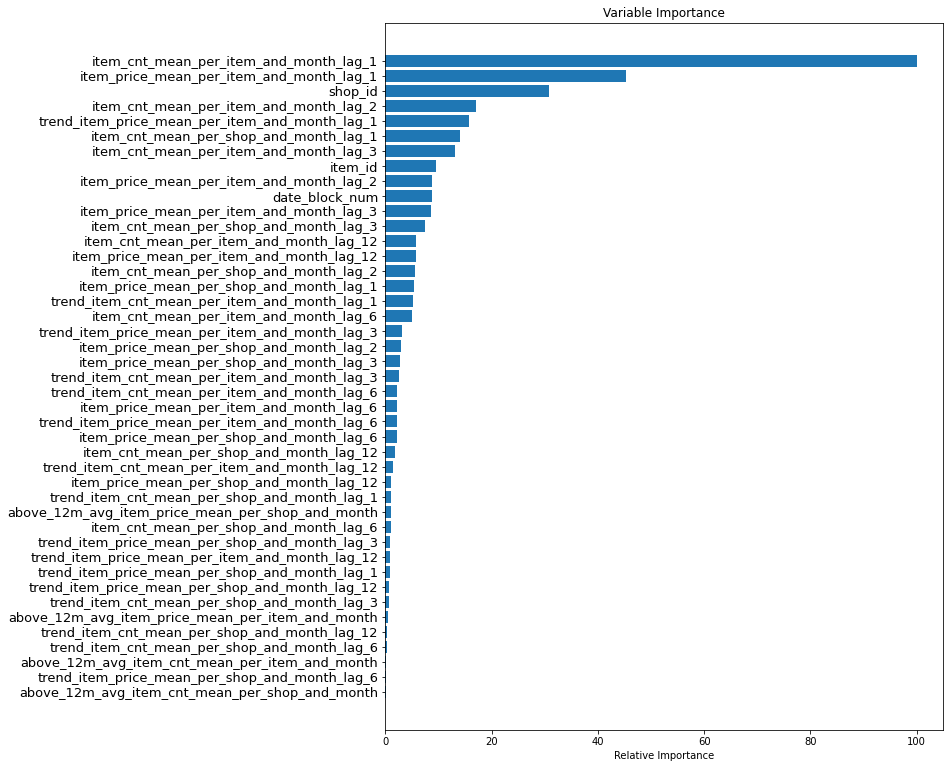

In [0]:
import matplotlib.pyplot as plt
# Plot feature importance - Results Visualization
feature_importance = gbt.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(10,13)) 
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.tick_params(axis='y', which='major', labelsize = 13)
plt.show()

Sumbission prep

In [0]:
model_name = 'gbt'

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": y_pred_test
})
submission.to_csv(model_name + '_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(y_pred_train, open(model_name + '_pred_train.pickle', 'wb'))
pickle.dump(y_pred_val, open(model_name + '_pred_val.pickle', 'wb'))
pickle.dump(y_pred_test, open(model_name + '_pred_test.pickle', 'wb'))

# save the model to disk
pickle.dump(model, open(model_name + '_model.sav', 'wb'))

 
# load the model from disk
'''
loaded_model = pickle.load(open(model_file_name, 'rb'))
result = loaded_model.score(X_test, Y_test)
print(result)
'''

"\nloaded_model = pickle.load(open(model_file_name, 'rb'))\nresult = loaded_model.score(X_test, Y_test)\nprint(result)\n"

EDA

In [0]:
df1 = data.describe(include = 'all')
df1.loc['dtype'] = data.dtypes
df1.loc['size'] = len(data)
df1.loc['% Null_count'] = data.isnull().mean()
df1

**Data Cleaning**

In [0]:
#impute any potential missing values or deal with outliers

Feature Engineering

In [0]:
# To construct month, year feature from data
# count of days in a month
# time components of item_price and item_cnt (value at t-1, t-2, t-3, t-6, t-12 maybe)
# rate of change of item_cnt (between t-1 and t-2 e.g.), 
# statistics on item_price and item_cnt - mean, std, range, mode, skew?


In [0]:
#Create a distinct day, month, year column
'''
df['date'] = pd.to_datetime(df['date'], format = "%d.%m.%Y")
df['year'], df['month'], features['day'] = df['date'].dt.year, df['date'].dt.month, df['date'].dt.day
df.head()
'''
#also get day count (days in a month)